<a href="https://colab.research.google.com/github/SachinPrasanth777/Cifar-10-Pytorch/blob/main/Cifar_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
check_gpu = torch.cuda.is_available()
if check_gpu:
    print('Training on GPU')
else:
    print('Training on CPU')

Training on CPU


In [ ]:
num_workers = 0 # Subprocesses for data loading
batch_size = 20 # Samples for each epoch
valid_data = 0.2 # Training Set for Validation

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_data = datasets.CIFAR10('data',train=True,download=True,transform=train_transform)
test_data = datasets.CIFAR10('data',train=False,download=False,transform=test_transform)

100%|██████████| 170M/170M [00:01<00:00, 103MB/s]


Extracting data/cifar-10-python.tar.gz to data


In [ ]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_data * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

(20, 3, 32, 32)

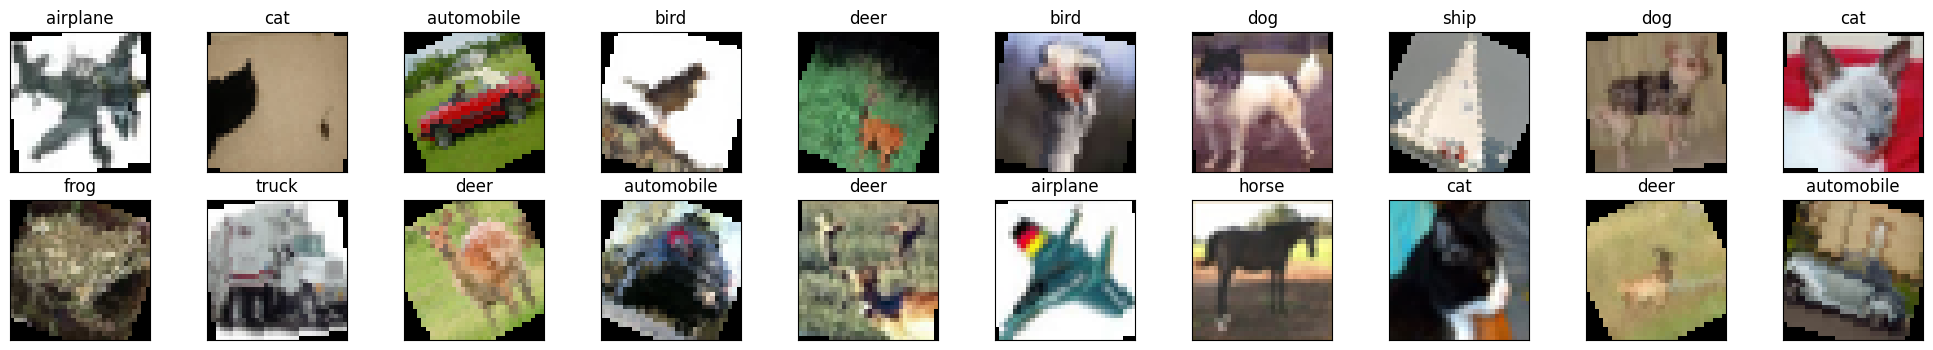

In [ ]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

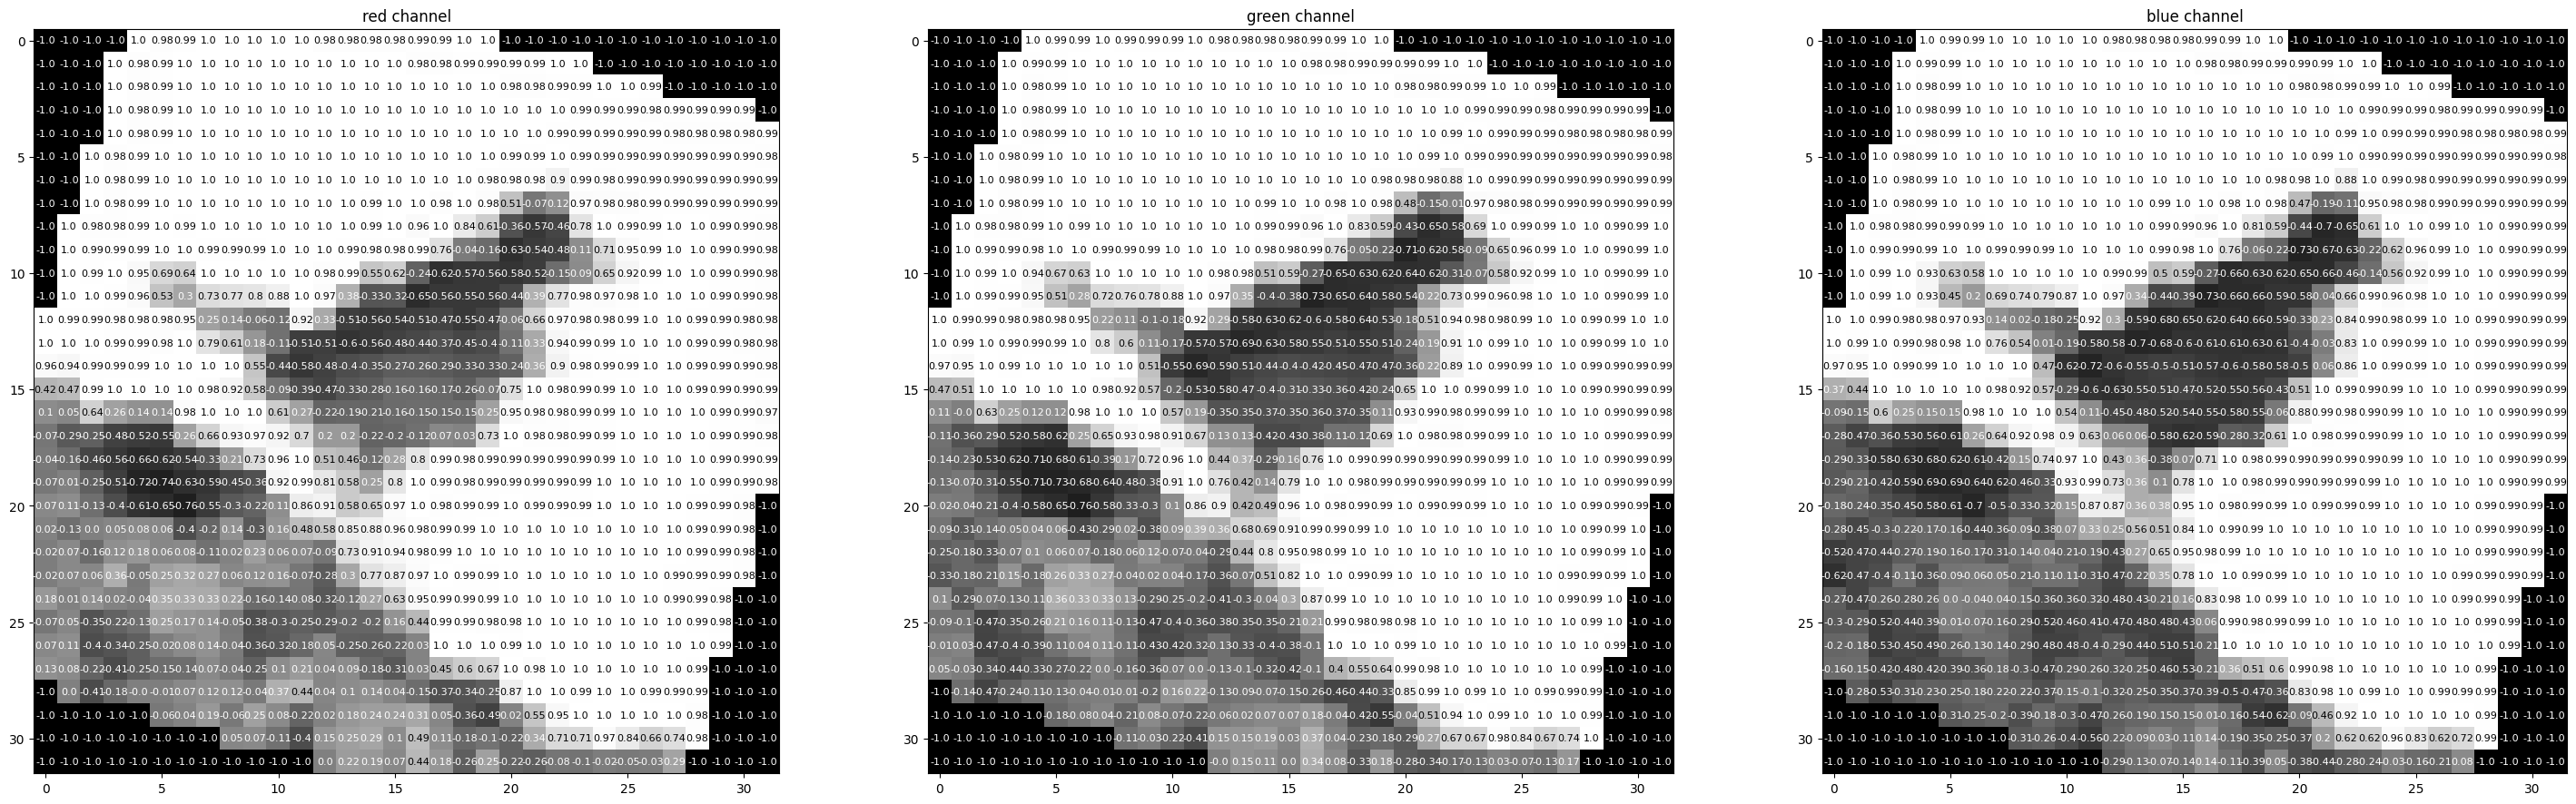

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = Net()
if check_gpu:
  model.cuda()
  print("Training on GPU")
else:
  print("Printing on CPU")

Printing on CPU


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [ ]:
epochs = 30
valid_loss_min = np.Inf
train_losses = []
valid_losses = []

for epoch in range(1, epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in train_loader:
        if check_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    model.eval()
    for data, target in valid_loader:
        if check_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(
            valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.848812 	Validation Loss: 0.819011
Validation loss decreased (inf --> 0.819011). Saving model...
Epoch: 2 	Training Loss: 0.844094 	Validation Loss: 0.817800
Validation loss decreased (0.819011 --> 0.817800). Saving model...
Epoch: 3 	Training Loss: 0.827018 	Validation Loss: 0.808848
Validation loss decreased (0.817800 --> 0.808848). Saving model...
Epoch: 4 	Training Loss: 0.824884 	Validation Loss: 0.796640
Validation loss decreased (0.808848 --> 0.796640). Saving model...
Epoch: 5 	Training Loss: 0.816549 	Validation Loss: 0.771935
Validation loss decreased (0.796640 --> 0.771935). Saving model...
Epoch: 6 	Training Loss: 0.814407 	Validation Loss: 0.783876
Epoch: 7 	Training Loss: 0.802846 	Validation Loss: 0.803813
Epoch: 8 	Training Loss: 0.792772 	Validation Loss: 0.776004
Epoch: 9 	Training Loss: 0.787026 	Validation Loss: 0.763630
Validation loss decreased (0.771935 --> 0.763630). Saving model...
Epoch: 10 	Training Loss: 0.779593 	Validation Loss: 0

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

<ipython-input-24-30c1fa6c7551>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_cifar.pt'))


<All keys matched successfully>

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for data, target in test_loader:
  if check_gpu:
    data, target = data.cuda(), target.cuda()
  output = model(data)
  loss = criterion(output,target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not check_gpu else np.squeeze(correct_tensor.cpu().numpy())
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.653479

Test Accuracy of airplane: 83% (834/1000)
Test Accuracy of automobile: 84% (843/1000)
Test Accuracy of  bird: 70% (703/1000)
Test Accuracy of   cat: 62% (621/1000)
Test Accuracy of  deer: 74% (744/1000)
Test Accuracy of   dog: 67% (676/1000)
Test Accuracy of  frog: 76% (760/1000)
Test Accuracy of horse: 85% (858/1000)
Test Accuracy of  ship: 84% (845/1000)
Test Accuracy of truck: 86% (863/1000)

Test Accuracy (Overall): 77% (7747/10000)


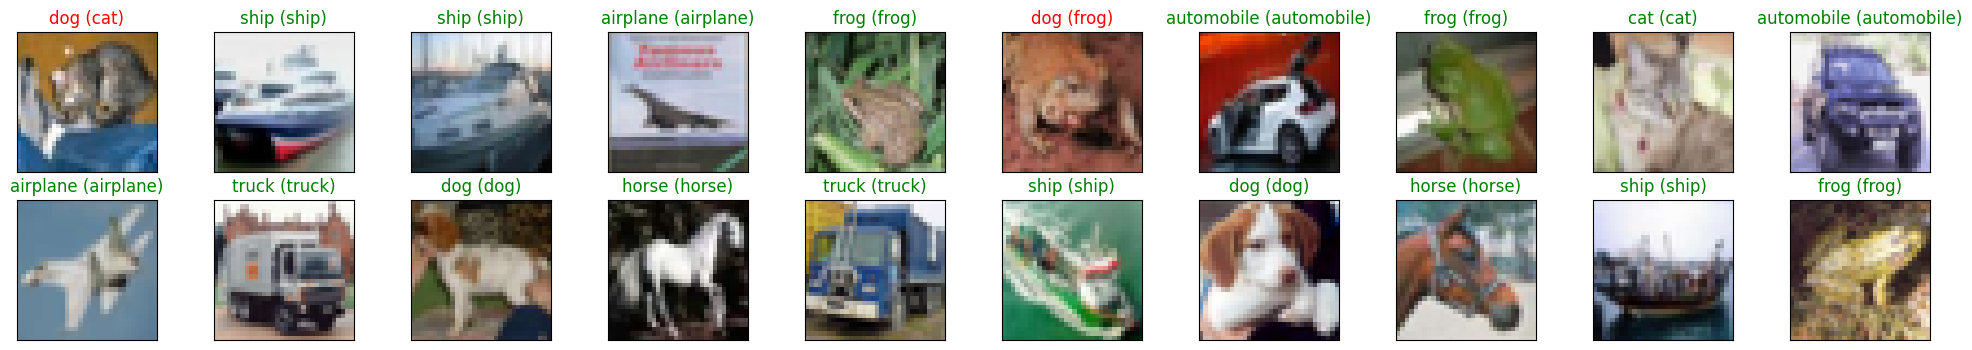

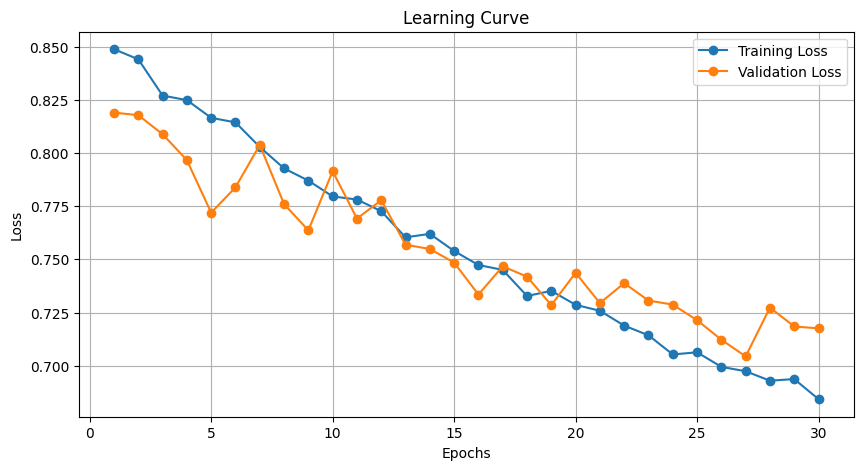

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

if check_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.cpu().numpy()) if check_gpu else np.squeeze(preds_tensor.numpy())

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx].cpu() if check_gpu else images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx] == labels[idx].item() else "red"))

plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
ax.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss", marker='o')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Learning Curve")
ax.legend()
ax.grid()
plt.show()